In [1]:
!pip install torchtext==0.6.0
import torch
import torch.nn as nn
import torch.optim as optim
import math
import torchtext
from tqdm import tqdm
import numpy as np
import pandas as pd
import gzip
import json
import spacy
import gc
from torchtext.vocab import build_vocab_from_iterator
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import random
import torch.nn.functional as F

def load_data(file_name, head=200000, sep=True):
    count = 0
    data, neg_data, pos_data = [], [], []
    with gzip.open(file_name) as fin:
        for l in fin:
            d = json.loads(l)
            count += 1
            if sep == True:
                bid, title, tws = d['book_id'], d['title'], d['title_without_series']
                data.append((bid, title, tws))
            else:
              if d['has_spoiler']:
                pos_data.append(d)
              else:
                neg_data.append(d)

            if (head is not None) and (count > head):
                break
    if sep:
      return data
    return pos_data, neg_data

# Libraries
import matplotlib.pyplot as plt
import pandas as pd
import torch

# Models
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from torchtext.data import Field, TabularDataset, BucketIterator

# Training
import torch.optim as optim

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from collections import defaultdict
import string

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.9 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.16.0
    Uninstalling torchtext-0.16.0:
      Successfully uninstalled torchtext-0.16.0


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)
tokenizer = torchtext.data.utils.get_tokenizer('basic_english')

In [5]:
gr_books = load_data("/content/drive/MyDrive/goodreads_books.json.gz", head=1e8)
t_data, f_data = load_data('/content/drive/MyDrive/goodreads_reviews_spoiler.json.gz', sep=False, head=1e8)

sentences_df = t_data + f_data

book_ids = {}
for bid, title, tws in gr_books:
    book_ids[bid] = title

In [6]:
t_len, t_rate = [], []
for t in t_data:
  t_rate.append(t['rating'])
  s = ''
  for i, sentence in t['review_sentences']:
    s += sentence + ' '
  t_len.append(len(s))

d_len, d_rate = [], []
for t in f_data:
  d_rate.append(t['rating'])
  s = ''
  for i, sentence in t['review_sentences']:
    s += sentence + ' '
  d_len.append(len(s))


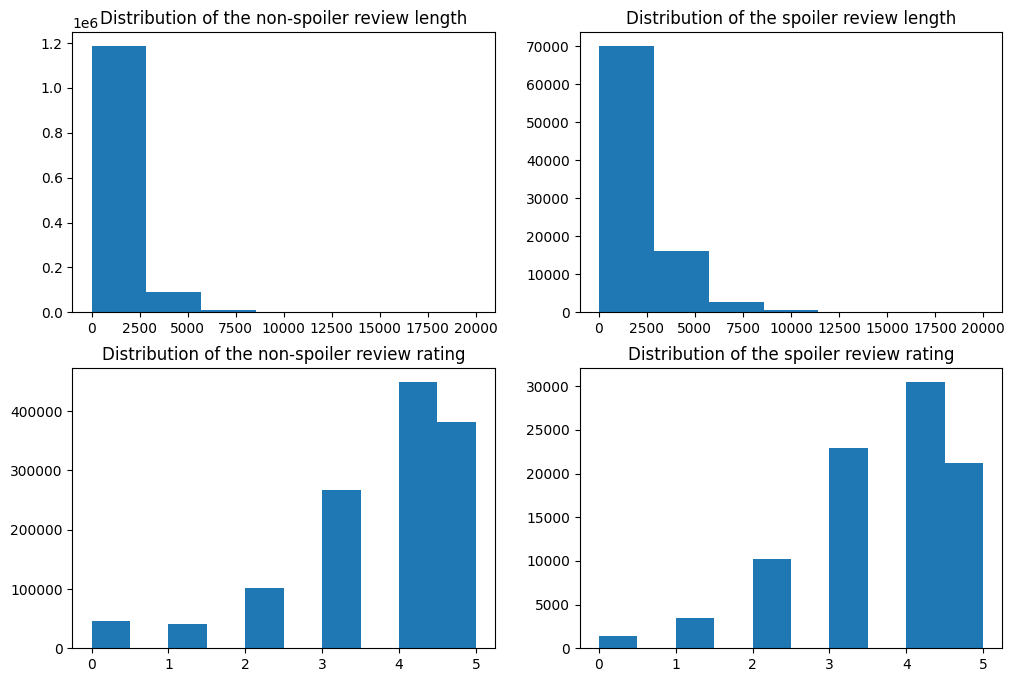

In [7]:
plt.figure(figsize=(12, 8))
bins = np.linspace(0, 20000, 8)
plt.subplot(2, 2, 1)
plt.hist(d_len, bins)
plt.title("Distribution of the non-spoiler review length")
plt.subplot(2, 2, 2)
plt.hist(t_len, bins)
plt.title("Distribution of the spoiler review length")
plt.subplot(2, 2, 3)
plt.hist(d_rate)
plt.title("Distribution of the non-spoiler review rating")
plt.subplot(2, 2, 4)
plt.hist(t_rate)
plt.title("Distribution of the spoiler review rating")
plt.show()

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
sl_pairs = []
cnt_has_spoiler_text, cnt_has_spoiler_sentence = 0, 0
total_sentences = 0
word_count = defaultdict(int)
punctuation = set(string.punctuation)
uids, bids = defaultdict(int), defaultdict(int)
spoiled_items, spoilers = [], []
num_rev_per_user, num_rev_per_item = [], []

for d in sentences_df:
    sentences = d['review_sentences']
    cnt_has_spoiler_text += d['has_spoiler']
    b, u = d['book_id'], d['user_id']
    if b not in bids:
        bids[b] = len(bids)
        spoiled_items.append(int(d['has_spoiler']))
        num_rev_per_item.append(1)
    else:
        bid = bids[b]
        spoiled_items[bid] += d['has_spoiler']
        num_rev_per_item[bid] += 1
    if u not in uids:
        uids[u] = len(uids)
        spoilers.append(int(d['has_spoiler']))
        num_rev_per_user.append(1)
    else:
        uid = uids[u]
        spoilers[uid] += d['has_spoiler']
        num_rev_per_user[uid] += 1
    for indicator, sentence in sentences:
        cnt_has_spoiler_sentence += indicator
        total_sentences += 1
        sl_pairs.append((indicator, sentence))
        r = ''.join([c for c in sentence if not c in punctuation])
        for w in r.split():
            word_count[w] += 1
print("# of Reviews: ", len(sentences_df), "; # of has spoiler review: ", cnt_has_spoiler_text)
print("# of sentences: ", total_sentences, "; # of has spoiler sentence: ", cnt_has_spoiler_sentence)
print("# of words: ", len(word_count.keys()))

# of Reviews:  1378033 ; # of has spoiler review:  89627
# of sentences:  17672655 ; # of has spoiler sentence:  569724
# of words:  1046111


In [ ]:
user_spoil_proportion = list(np.array(spoilers) / np.array(num_rev_per_user))
book_spoil_proportion = list(np.array(spoiled_items) / np.array(num_rev_per_item))

In [ ]:
pos_dataset, neg_dataset = [], []
for d in sentences_df:
    bid, uid = bids[d['book_id']], uids[d['user_id']]
    title = book_ids[d['book_id']]
    s = ''
    for label, sentence in d['review_sentences']:
        s += sentence + ' '
    if d['has_spoiler'] == 0:
      neg_dataset.append(("Book Title: " + title + "; Review: " + s, d['has_spoiler'], user_spoil_proportion[uid], book_spoil_proportion[bid]))
    else:
      pos_dataset.append(("Book Title: " + title + "; Review: " + s, d['has_spoiler'], user_spoil_proportion[uid], book_spoil_proportion[bid]))
# for d in f_data:
#     title = book_ids[d['book_id']]
#     s = ''
#     for label, sentence in d['review_sentences']:
#         s += sentence + ' '
#     neg_dataset.append(("Book Title: " + title + "; Review: " + s, d['has_spoiler']))
print(neg_dataset[0])

('Book Title: Invisible Man; Review: Recommended by Don Katz. Avail for free in December: http://www.audible.com/mt/ellison2?so... ', False, 0.08433734939759036, 0.03333333333333333)


In [ ]:
random.shuffle(neg_dataset)
neg_dataset = neg_dataset[:120000]
new_dataset = neg_dataset + pos_dataset
print(len(new_dataset))

209627


In [ ]:
destination_folder = '.'
train_test_ratio=0.9
train_valid_ratio=0.889
df = pd.DataFrame(new_dataset, columns=['text', 'label', "user_prop", "book_prop"])
df.loc[df['label'] == False, 'label'] = 0
df.loc[df['label'] == True, 'label'] = 1
df_real = df[df['label'] == 0]
df_fake = df[df['label'] == 1]

# Train-test split
df_real_full_train, df_real_test = train_test_split(df_real, train_size = train_test_ratio, random_state = 1)
df_fake_full_train, df_fake_test = train_test_split(df_fake, train_size = train_test_ratio, random_state = 1)

# Train-valid split
df_real_train, df_real_valid = train_test_split(df_real_full_train, train_size = train_valid_ratio, random_state = 1)
df_fake_train, df_fake_valid = train_test_split(df_fake_full_train, train_size = train_valid_ratio, random_state = 1)

# Concatenate splits of different labels
df_train = pd.concat([df_real_train, df_fake_train], ignore_index=True, sort=False)
df_valid = pd.concat([df_real_valid, df_fake_valid], ignore_index=True, sort=False)
df_test = pd.concat([df_real_test, df_fake_test], ignore_index=True, sort=False)

# Write preprocessed data
destination_folder = '.'
df_train.to_csv(destination_folder + '/train_ub.csv', index=False)
df_valid.to_csv(destination_folder + '/valid_ub.csv', index=False)
df_test.to_csv(destination_folder + '/test_ub.csv', index=False)

In [ ]:
df_train = pd.read_csv('train.csv')
df_valid = pd.read_csv('valid.csv')
df_test = pd.read_csv('test.csv')
df_train.head()

,text,label
0,Book Title: No Country for Old Men; Review: St...,0
1,Book Title: Lord of Emperors (The Sarantine Mo...,0
2,Book Title: The Redemption of Callie & Kayden ...,0
3,"Book Title: Equal Rites (Discworld, #3; Witche...",0
4,"Book Title: Wonder; Review: Wow, definitely an...",0


In [ ]:
# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.long)
text_field = Field(tokenize='basic_english', lower=True, include_lengths=True, batch_first=True)
fields = [('text', text_field), ('label', label_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path='/content/drive/MyDrive/Colab Notebooks/cse258_assignment2/', train='train.csv', validation='valid.csv', test='test.csv',
                                           format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)

# Vocabulary

text_field.build_vocab(train, min_freq=3)

In [ ]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
class LSTM(nn.Module):

    def __init__(self, dimension=128):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(len(text_field.vocab), 300)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.5)

        self.fc = nn.Linear(2*dimension, 2)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)

        packed_input = pack_padded_sequence(text_emb, text_len.detach().cpu(), batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len.detach().cpu() - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)

        text_fea = self.fc(text_fea)
        text_out = torch.squeeze(text_fea, 1)
        # text_out = torch.sigmoid(text_fea)

        return text_out

In [ ]:
def save_checkpoint(save_path, model, optimizer, valid_loss):
    if save_path == None:
        return

    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}

    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):
    if load_path==None:
        return

    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')

    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])

    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):
    if save_path == None:
        return

    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}

    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):
    if load_path==None:
        return

    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')

    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [ ]:
import time

def train(model,
          optimizer,
          criterion = nn.BCEWithLogitsLoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 4,
          file_path = '.',
          best_valid_loss = float("Inf")):

    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        t1 = time.time()
        for i, (((titletext, titletext_len), labels), _) in enumerate(train_loader):
            labels = labels.to(device, dtype=torch.long)
            labels = F.one_hot(labels, 2).to(dtype=torch.float32)
            titletext = titletext.to(device)
            titletext_len = titletext_len.to(device)
            output = model(titletext, titletext_len)

            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # update running values
            running_loss += loss.item()
            global_step += 1
            if i % 1000 == 0:
                # print(i)
                t2 = time.time()
                # print(t2 - t1)
                t1 = t2

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():
                  # validation loop
                  for ((titletext, titletext_len), labels), _  in valid_loader:
                      labels = labels.to(device)
                      labels = F.one_hot(labels, 2).to(dtype=torch.float32)
                      titletext = titletext.to(device)
                      titletext_len = titletext_len.to(device)
                      output = model(titletext, titletext_len)
                      loss = criterion(output, labels)
                      valid_running_loss += loss.item()
                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)
                # resetting running values
                running_loss = 0.0
                valid_running_loss = 0.0
                model.train()
                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))

                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)

    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')


model = LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
train(model=model, optimizer=optimizer, num_epochs=10)

Epoch [1/10], Step [1310/52420], Train Loss: 0.2832, Valid Loss: 0.6967
Model saved to ==> ./model.pt
Model saved to ==> ./metrics.pt
Epoch [1/10], Step [2620/52420], Train Loss: 0.6019, Valid Loss: 0.5984
Model saved to ==> ./model.pt
Model saved to ==> ./metrics.pt
Epoch [1/10], Step [3930/52420], Train Loss: 0.6101, Valid Loss: 0.6043
Epoch [1/10], Step [5240/52420], Train Loss: 0.5460, Valid Loss: 1.1015
Epoch [2/10], Step [6550/52420], Train Loss: 0.2342, Valid Loss: 0.6244
Epoch [2/10], Step [7860/52420], Train Loss: 0.5233, Valid Loss: 0.5259
Model saved to ==> ./model.pt
Model saved to ==> ./metrics.pt
Epoch [2/10], Step [9170/52420], Train Loss: 0.5425, Valid Loss: 0.5349
Epoch [2/10], Step [10480/52420], Train Loss: 0.4942, Valid Loss: 0.9810
Epoch [3/10], Step [11790/52420], Train Loss: 0.1991, Valid Loss: 0.5485
Epoch [3/10], Step [13100/52420], Train Loss: 0.4628, Valid Loss: 0.5067
Model saved to ==> ./model.pt
Model saved to ==> ./metrics.pt
Epoch [3/10], Step [14410/524

In [ ]:
75274

Model loaded from <== ./model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.7335    0.6935    0.7130      8963
           0     0.7800    0.8118    0.7956     12000

    accuracy                         0.7612     20963
   macro avg     0.7568    0.7527    0.7543     20963
weighted avg     0.7602    0.7612    0.7603     20963



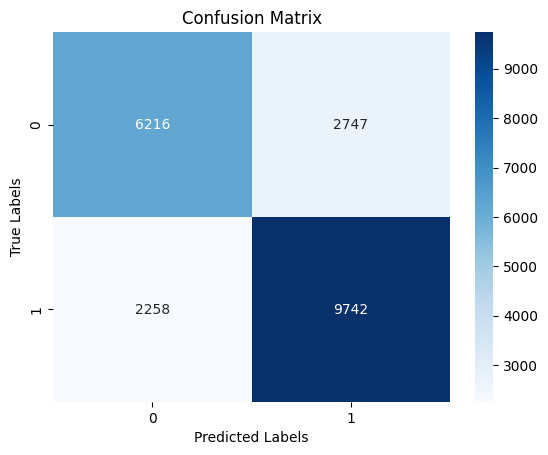

In [ ]:
def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for ((titletext, titletext_len), labels), _ in test_loader:
            labels = labels.to(device)
            titletext = titletext.to(device)
            titletext_len = titletext_len.to(device)
            output = model(titletext, titletext_len)
            output = torch.argmax(F.sigmoid(output), dim=1)

            # output = (output > threshold).int()
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())

    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels([0, 1])
    ax.yaxis.set_ticklabels([0, 1])


best_model = LSTM().to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint('.' + '/model.pt', best_model, optimizer)
evaluate(best_model, test_iter)